In [2]:
import os
import yaml
from torch.utils.data import DataLoader
import argparse

from GeospatialFM.data import get_datasets
from GeospatialFM.models import *
# from utils import load_config
from torchgeo.samplers import RandomGeoSampler
from matplotlib import pyplot as plt

from transformers import TrainingArguments, Trainer
from transformers import AdamW, get_linear_schedule_with_warmup
from GeospatialFM.utils import setup, get_eval_fn, get_data
from GeospatialFM.data import *
from GeospatialFM.models import *
from GeospatialFM.loss import *

from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import numpy as np
from torch.utils.data import ConcatDataset
import segmentation_models_pytorch as smp

%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device('cuda:0')

In [4]:
args = {'exp_name': None,
        'config_file': 'GeospatialFM/configs/mae_cm.yaml',
        'opts': None, 
        'save_config': False}
args = argparse.Namespace(**args)
args.debug = True
args.finetune = False
args

Namespace(exp_name=None, config_file='GeospatialFM/configs/mae_cm.yaml', opts=None, save_config=False, debug=True, finetune=False)

In [5]:
cfg, _ = setup(args)

In [6]:
cfg.DATASET['train_transforms']['normalize'] = True
cfg.DATASET['train_transforms']['standardize'] = False

In [7]:
data = get_data(cfg)
data

{'train': DataInfo(dataloader=<torch.utils.data.dataloader.DataLoader object at 0x7f25c2b1c220>, sampler=None, shared_epoch=None),
 'val': DataInfo(dataloader=<torch.utils.data.dataloader.DataLoader object at 0x7f25c2b1c520>, sampler=None, shared_epoch=None),
 'test': DataInfo(dataloader=<torch.utils.data.dataloader.DataLoader object at 0x7f25c2b1c8b0>, sampler=None, shared_epoch=None)}

In [8]:
sample = iter(data['test'].dataloader).__next__()

In [ ]:
sample['image'].shape

torch.Size([512, 13, 224, 224])

In [ ]:
model = construct_mae(cfg.MODEL)

In [ ]:
device = 'cuda:0'
device_ids = [0, 1, 2, 3]

In [ ]:
model = model.to(device)
model = torch.nn.DataParallel(model, device_ids=device_ids)

In [ ]:
loss = get_loss_list(cfg.LOSS)

In [ ]:
loss

[ClipLoss(), MAELoss()]

In [9]:
device = torch.device(device)

In [15]:
# image = sample['image'].to(device, non_blocking=True)
# radar = sample['radar'].to(device, non_blocking=True)
image = sample['image']
radar = sample['radar']

In [30]:
model_out = model(image, radar)
logit_scale = model_out.get("logit_scale").mean()
model_out['logit_scale'] = logit_scale

NameError: name 'model' is not defined

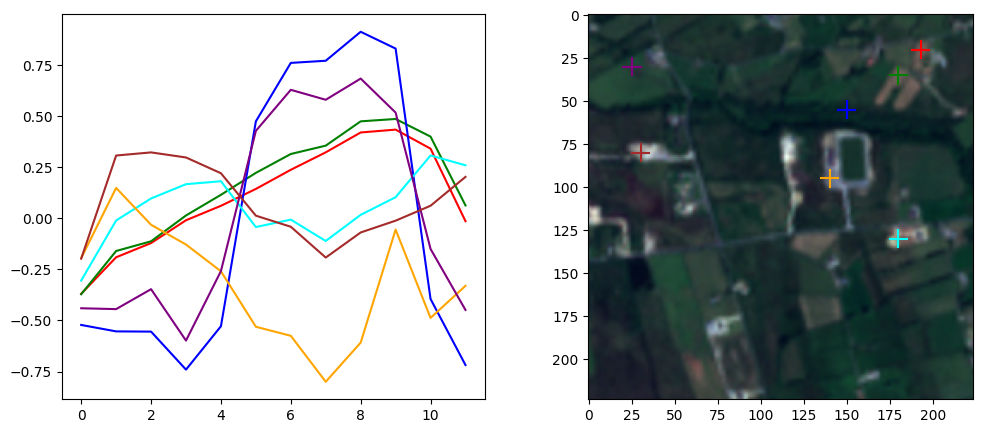

In [22]:
points = [[20, 193], [35, 180], [55, 150], [130, 180], [95, 140], [30, 25], [80, 30]]
cross_length = 5
img_id = 100
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
color = ['r', 'g', 'b', 'cyan', 'orange', 'purple', 'brown']
for c, point in enumerate(points):
    curve = image[img_id, :, point[0], point[1]].detach().cpu().numpy()
    curve = np.delete(curve, 10)
    plt.plot(np.arange(12), curve, color[c])
vis_img = image[img_id, [3, 2, 1], :, :].detach().cpu().numpy().transpose(1, 2, 0)
# normalize each channel
vis_img = (vis_img - vis_img.min()) / (vis_img.max() - vis_img.min())

plt.subplot(1, 2, 2)
plt.imshow(vis_img)
# draw a cross at the point
for c, point in enumerate(points):
    plt.plot([point[1] - cross_length, point[1] + cross_length], [point[0], point[0]],  color[c]) 
    # Draw vertical line of the cross
    plt.plot([point[1], point[1]], [point[0] - cross_length, point[0] + cross_length],  color[c]) 
# plt.axis('off')

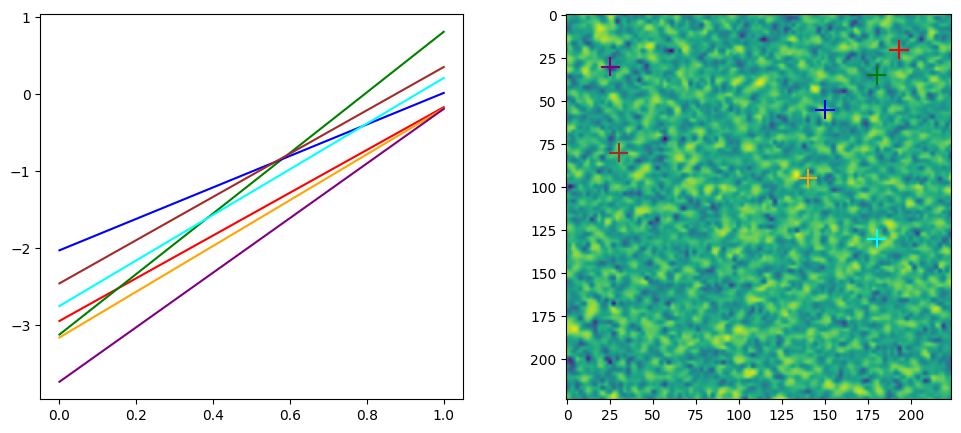

In [21]:
points = [[20, 193], [35, 180], [55, 150], [130, 180], [95, 140], [30, 25], [80, 30]]
cross_length = 5
img_id = 150
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
color = ['r', 'g', 'b', 'cyan', 'orange', 'purple', 'brown']
for c, point in enumerate(points):
    curve = radar[img_id, :, point[0], point[1]].detach().cpu().numpy()
    # curve = np.delete(curve, 10)
    plt.plot(np.arange(2), curve, color[c])
vis_img = radar[img_id, [0], :, :].detach().cpu().numpy().transpose(1, 2, 0)
# normalize each channel
vis_img = (vis_img - vis_img.min()) / (vis_img.max() - vis_img.min())

plt.subplot(1, 2, 2)
plt.imshow(vis_img)
# draw a cross at the point
for c, point in enumerate(points):
    plt.plot([point[1] - cross_length, point[1] + cross_length], [point[0], point[0]],  color[c]) 
    # Draw vertical line of the cross
    plt.plot([point[1], point[1]], [point[0] - cross_length, point[0] + cross_length],  color[c]) 
# plt.axis('off')